In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('font', family='Times New Roman')
plt.rcParams["mathtext.fontset"] = 'stix'

#width = 3.37 or 6.69 eps are preferred

In [2]:
def bad_probe(probe, threshold=10.0):
    """Apply a low-pass filter to the probe in frequency space."""
    def center_range(L):
        return np.arange(L) - 0.5 * (L - 1)
    # Generate the low-pass filter
    x, y = np.meshgrid(
        center_range(probe.shape[0]),
        center_range(probe.shape[1]),
    )
    mask = x * x + y * y > threshold * threshold * probe.shape[0] * probe.shape[1] * 0.25
    # Apply the filer in frequency space
    data = np.fft.fft2(probe)
    data = np.fft.fftshift(data)
    data[mask] = 0
    data = np.fft.ifftshift(data)
    return np.fft.ifft2(data)

In [3]:
#########|#########|#########|#########|#########|#########|#########|#########|

import matplotlib.gridspec as gridspec
import matplotlib

def set_spine_color(ax, color):
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color(color)
#             child.set_linestyle((2, 1))


def fig_illumination_compare(name, probes, labels):
    """"""
    plt.figure(figsize=(3.37, 3.37), dpi=200)

    nrows = 2
    ncols = len(probes)
    
    divide = 0.4
    
    gs = gridspec.GridSpec(nrows, ncols)
    gs.update(left=0.06, right=0.99, bottom=divide+0.1, top=1.-0.05,)
    
    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(left=0.15, right=0.99, bottom=0.08, top=divide)
    
    linestyles = [(3, 1), (1, 1, 3, 1), (1, 1), (1, 0), (5, 1)]

    nearfield = np.square(np.abs(probes))
    farfield = np.square(np.abs(
        np.fft.fftshift(np.fft.fft2(probes, axes=[-1, -2]), axes=[-1, -2])
    ))
    
    for i, probe in enumerate(probes):        
        # draw the probe
        plt.subplot(gs[0, i])
        plt.imshow(nearfield[i], vmax=np.max(nearfield), cmap=plt.cm.magma_r)
        print("nearfield sum intensity {}".format(np.sum(farfield[i])))
        plt.xticks([])
        plt.yticks([])
        plt.title(labels[i])
#         plt.colorbar()
        if i == 0:
            plt.ylabel('near-field')
#         set_spine_color(plt.gca(), 'red')
            
        # draw the FFT
        plt.subplot(gs[1, i])
        plt.imshow(np.log10(farfield[i]), vmin=0, vmax=np.log10(np.max(farfield)), cmap=plt.cm.magma_r)
        print("farfield sum intensity {}".format(np.sum(farfield[i])))
#         plt.colorbar()
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('log(far-field)')
        
        plt.subplots_adjust(hspace=0.05, wspace=0.05)

        # draw line through FFT
        plt.subplot(gs2[0])
        plt.semilogy(farfield[i][farfield[i].shape[0]//2,:], dashes=linestyles[i], linewidth=1)
        plt.legend(labels, ncol=5, frameon=False, loc=(-0.15, 1), columnspacing=1/2, handletextpad=1/8)
        plt.ylabel('log(far-field)')

    plt.savefig(name, dpi=600)
    plt.show()

MURA is length 113
(37, 37)
(256, 256)
(256, 256)
nearfield sum intensity 65535.995338184366
farfield sum intensity 65535.995338184366
nearfield sum intensity 65536.0018919474
farfield sum intensity 65536.0018919474
nearfield sum intensity 65536.00189194741
farfield sum intensity 65536.00189194741
nearfield sum intensity 65536.0
farfield sum intensity 65536.0


/home/beams/DCHING/miniconda3/envs/tike/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


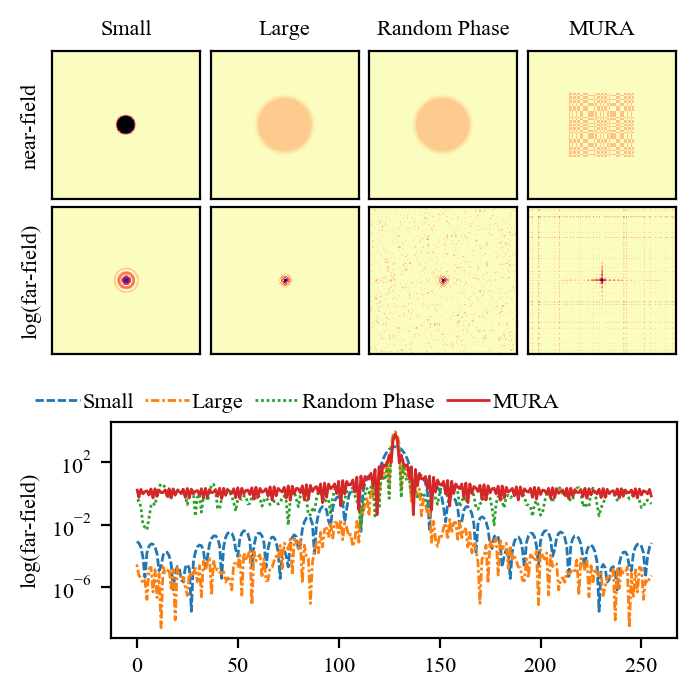

In [8]:
import tike
import xdesign
import numpy as np

def sum_square_norm(x, N=1):
    """Return x normalized such that the sum of squares of x equals N."""
    x1 = np.sqrt(np.square(x) / np.sum(np.square(x)) * N)
    np.testing.assert_almost_equal(np.sum(np.square(np.abs(x1))), N)
    return x1

pw = 113

# Normalize both probes so their integrals are 1
mura = xdesign.mura_2d(pw) 
mura = sum_square_norm(mura)
# mura = mura * np.exp(1j * np.random.rand(61, 61) * 2 * np.pi)
gaussian = tike.ptycho.gaussian(len(mura))
gaussian = sum_square_norm(gaussian)
mixed = gaussian * np.exp(1j * tike.ptycho.gaussian(len(mura)) * np.pi * 0.5 * (np.random.rand(pw, pw) * 2 - 1))
sgaussian = tike.ptycho.gaussian(len(mura) // 3)
print(sgaussian.shape)
sgaussian = sum_square_norm(sgaussian)

# debrujin = np.load('./debruijn.npy')
# debrujin = sum_square_norm(debrujin)

# pad each to the detector size
detector_size = 256
padx = (detector_size - len(mura)) // 2 
probe_mura = np.pad(mura, [padx, padx+1], 'constant')
probe_gauss = np.pad(gaussian, [padx, padx+1], 'constant')
probe_mixed = np.pad(mixed, [padx, padx+1], 'constant')
# probe_debruj = np.pad(debrujin, [padx, padx+1], 'constant')


padx = (detector_size - len(sgaussian)) // 2
probe_small = np.pad(sgaussian, [padx, padx+1], 'constant')

s = 77
probe_multi = np.copy(probe_small)
probe_multi += np.roll(probe_small, (0, s), (0, 1))
probe_multi += np.roll(probe_small, (-s, 0), (0, 1))
probe_multi += np.roll(probe_small, (0, -s), (0, 1))
probe_multi += np.roll(probe_small, (s, 0), (0, 1))
probe_multi += np.roll(probe_small, (-s, s), (0, 1))
probe_multi += np.roll(probe_small, (-s, -s), (0, 1))
probe_multi += np.roll(probe_small, (s, -s), (0, 1))
probe_multi += np.roll(probe_small, (s, s), (0, 1))
probe_multi = sum_square_norm(probe_multi)

print(probe_small.shape)
print(probe_gauss.shape)

fig_illumination_compare(
    "./figures/FFT_compare.pdf",
    [probe_small, probe_gauss, probe_mixed, probe_mura, ],
    labels=['Small', 'Large', 'Random Phase', 'MURA', ])

nearfield sum intensity 16384.000852036246
farfield sum intensity 16384.000852036246
nearfield sum intensity 16383.999419815194
farfield sum intensity 16383.999419815194
nearfield sum intensity 16383.998714927482
farfield sum intensity 16383.998714927482
nearfield sum intensity 16383.99891530889
farfield sum intensity 16383.99891530889
nearfield sum intensity 16384.00013266114
farfield sum intensity 16384.00013266114


/home/beams/DCHING/miniconda3/envs/tike/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in log10
/home/beams/DCHING/miniconda3/envs/tike/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


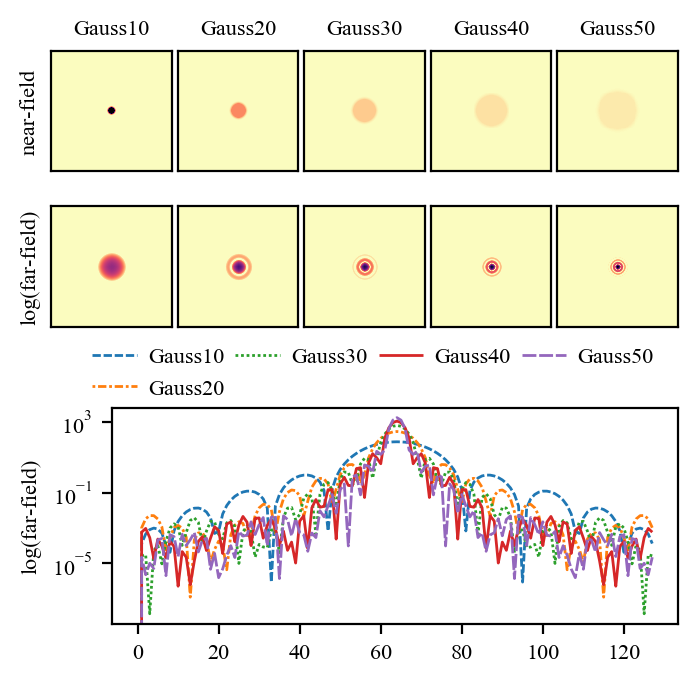

In [5]:
import tike
import xdesign
import numpy as np

gaussians = list()

# Normalize both probes so their integrals are 1
for size in [10, 20, 30, 40, 50]:
    gaussian = tike.ptycho.gaussian(size)
    gaussian = sum_square_norm(gaussian)

    # pad each to the detector size
    detector_size = 128
    padx = (detector_size - len(gaussian)) // 2 
    gaussians.append(np.pad(gaussian, padx, 'constant'))

fig_illumination_compare(
    "./figures/FFT_compare_sizes.pdf",
    gaussians,
    labels=['Gauss10', 'Gauss20', 'Gauss30', 'Gauss40', 'Gauss50'])

In [6]:
# import tike
# import xdesign
# import numpy as np

# # Normalize both probes so their integrals are 1
# mura = xdesign.mura_2d(64)
# mura = mura / np.sum(mura)
# gaussian = tike.ptycho.gaussian(len(mura))
# gaussian = gaussian / np.sum(gaussian)


# # assert np.sum(mura) == 1, print(np.sum(mura))
# # assert np.sum(gaussian) == 1, print(np.sum(gaussian))

# # pad each to the detector size
# detector_size = 64
# padx = (detector_size - len(mura)) // 2 
# probe_mura = np.pad(mura, padx, 'constant')
# probe_gauss = np.pad(gaussian, padx, 'constant')

# fig_illumination_compare(
#     [probe_mura, probe_gauss, np.real(bad_probe(probe_gauss, 0.1))],
#     labels=['MURA', 'Gaussian', 'Bad Probe'])